## Analyzing the Penguin Dataset with Support Vector Machines

In [1]:
import numpy as np
import pandas as pd
from numpy.random import default_rng
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import CategoricalColorMapper
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
rng = default_rng(5)
output_notebook()

Loading BokehJS ...

Corresponding hyperplane function to that discussed in $R$. This can be used with a linear kernel like that in the maximal margin classifier or support vector classifier.

In [2]:
def hyperplane(P,x,z=0):
    """Given an SVC object P and an array of vectors x, computes the hyperplane wx+b=z"""
    alphas = P.dual_coef_
    svs = P.support_vectors_
    c = P.intercept_[0]-z
    a = np.sum(alphas.T*svs,axis=0)[0]
    b = np.sum(alphas.T*svs,axis=0)[1]
    return (-c-a*x)/b

Importing dataset

In [3]:
df = pd.read_csv('/Users/juliaandronowitz/Desktop/thesis/thesis/Data/penguins_size.csv')

Initial exploration of data

In [4]:
df.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [6]:
def rstr(df): return df.shape, df.apply(lambda x: [x.unique()])
rstr(df)

((344, 7),
                        species                      island  \
 0  [Adelie, Chinstrap, Gentoo]  [Torgersen, Biscoe, Dream]   
 
                                     culmen_length_mm  \
 0  [39.1, 39.5, 40.3, nan, 36.7, 39.3, 38.9, 39.2...   
 
                                      culmen_depth_mm  \
 0  [18.7, 17.4, 18.0, nan, 19.3, 20.6, 17.8, 19.6...   
 
                                    flipper_length_mm  \
 0  [181.0, 186.0, 195.0, nan, 193.0, 190.0, 180.0...   
 
                                          body_mass_g                     sex  
 0  [3750.0, 3800.0, 3250.0, nan, 3450.0, 3650.0, ...  [MALE, FEMALE, nan, .]  )

In [7]:
df.describe()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


In [8]:
df.isna().sum()

species               0
island                0
culmen_length_mm      2
culmen_depth_mm       2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64

Dropping the rows with values of NaN

In [9]:
df = df.dropna()

Creating a list of labels for each penguin species

In [10]:
labels = []
x = 0
for i in df['species']:
    if i == 'Adelie':
        x = 0
    elif i == 'Chinstrap':
        x = 1
    elif i == 'Gentoo':
        x = 2
    labels.append(x)

These assignments will be used later in graphing the functions. Red will be Adelie, blue is Chinstrap, and green is Gentoo:

In [11]:
colors = ['red','blue','green']
penguin_colors = np.array([colors[i] for i in labels])

Removing species (the class label), island, and sex

In [12]:
data = df.drop(columns=['species','island','sex'])

In [13]:
data.head()

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
4,36.7,19.3,193.0,3450.0
5,39.3,20.6,190.0,3650.0


Converting to numpy array

In [14]:
data = data.to_numpy()

In [15]:
data

array([[  39.1,   18.7,  181. , 3750. ],
       [  39.5,   17.4,  186. , 3800. ],
       [  40.3,   18. ,  195. , 3250. ],
       ...,
       [  50.4,   15.7,  222. , 5750. ],
       [  45.2,   14.8,  212. , 5200. ],
       [  49.9,   16.1,  213. , 5400. ]])

Plotting the raw data points

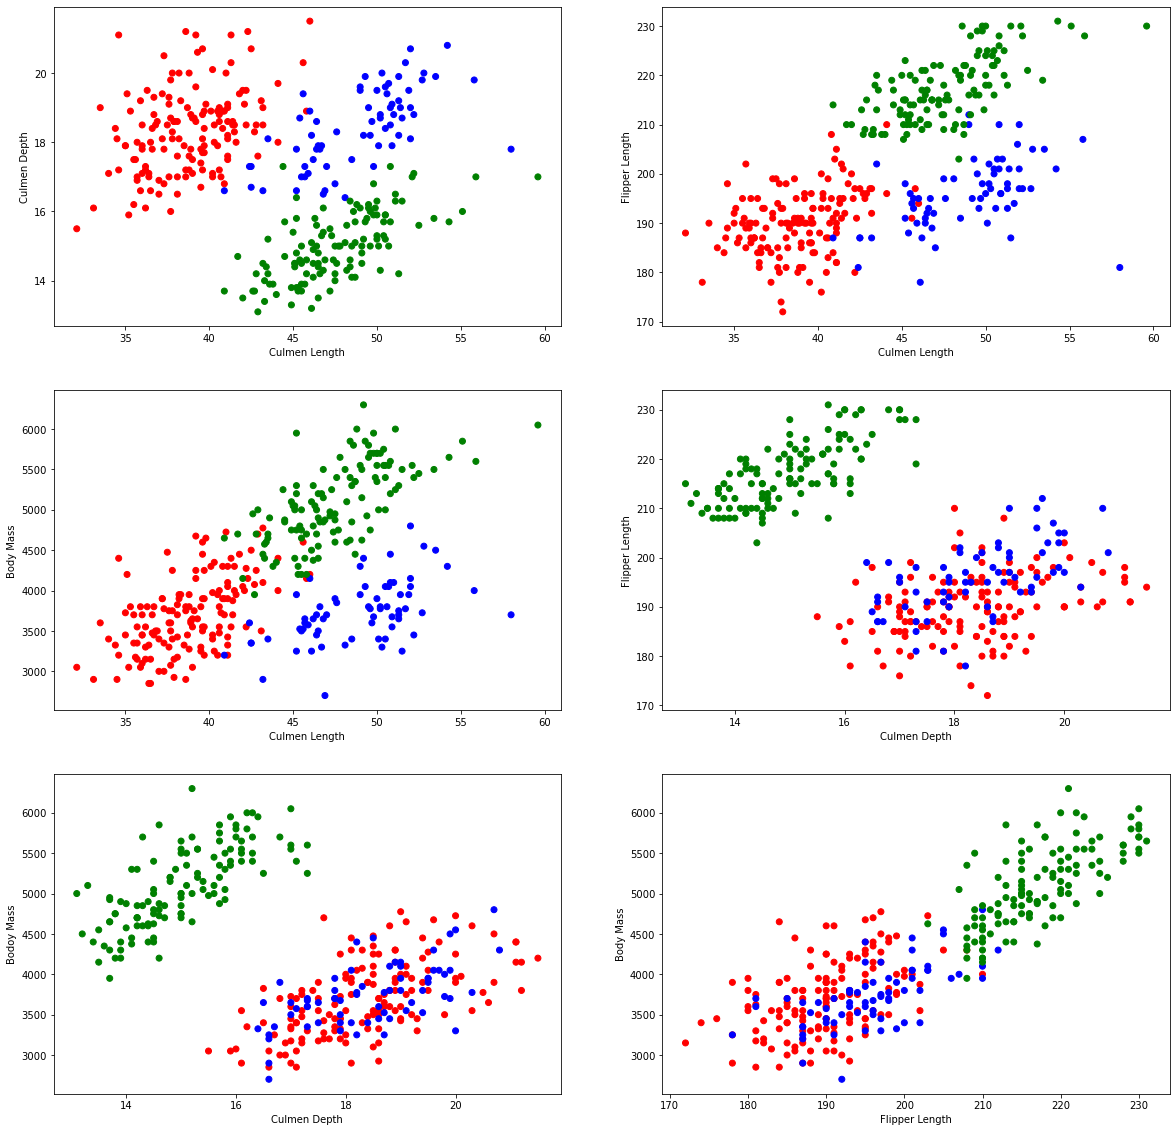

In [68]:
fig, axs = plt.subplots(3,2, figsize=(20, 20))

axs[0,0].scatter(x=data[:,0],y=data[:,1],color=penguin_colors)
axs[0,0].set_xlabel("Culmen Length")
axs[0,0].set_ylabel("Culmen Depth")

axs[0,1].scatter(x=data[:,0],y=data[:,2],color=penguin_colors)
axs[0,1].set_xlabel("Culmen Length")
axs[0,1].set_ylabel("Flipper Length")

axs[1,0].scatter(x=data[:,0],y=data[:,3],color=penguin_colors)
axs[1,0].set_xlabel("Culmen Length")
axs[1,0].set_ylabel("Body Mass")

axs[1,1].scatter(x=data[:,1],y=data[:,2],color=penguin_colors)
axs[1,1].set_xlabel("Culmen Depth")
axs[1,1].set_ylabel("Flipper Length")

axs[2,0].scatter(x=data[:,1],y=data[:,3],color=penguin_colors)
axs[2,0].set_xlabel("Culmen Depth")
axs[2,0].set_ylabel("Bodoy Mass")

axs[2,1].scatter(x=data[:,2],y=data[:,3],color=penguin_colors)
axs[2,1].set_xlabel("Flipper Length")
axs[2,1].set_ylabel("Body Mass")

# saving plot
# plt.savefig('/Users/juliaandronowitz/Desktop/thesis/thesis/Figures/penguins/penguins_raw_data_plots.png')

plt.show()


In [65]:
# plot for individual graph

# cl_cd=figure(title='Penguin Data: culmen length vs. culmen depth')
# cl_cd.scatter(x=data[:,0],y=data[:,1],color=penguin_colors)
# show(cl_cd)

In [60]:
# plot for individual graph

# cl_fl=figure(title='Penguin Data: culmen length vs. flipper length')
# cl_fl.scatter(x=data[:,0],y=data[:,2],color=penguin_colors)
# show(cl_fl)

In [61]:
# plot for individual graph

# cl_bm=figure(title='Penguin Data: culmen length vs. body mass')
# cl_bm.scatter(x=data[:,0],y=data[:,3],color=penguin_colors)
# show(cl_bm)

In [62]:
# plot for individual graph

# cd_fl=figure(title='Penguin Data: culmen depth vs. flipper length')
# cd_fl.scatter(x=data[:,1],y=data[:,2],color=penguin_colors)
# show(cd_fl)

In [63]:
# plot for individual graph

# cd_bm=figure(title='Penguin Data: culmen depth vs. body mass')
# cd_bm.scatter(x=data[:,1],y=data[:,3],color=penguin_colors)
# show(cd_bm)

In [64]:
# plot for individual graph

# fl_bm=figure(title='Penguin Data: flipper length vs. body mass')
# fl_bm.scatter(x=data[:,2],y=data[:,3],color=penguin_colors)
# show(fl_bm)

try 3 different classifications:

1. culmen length vs. culmen depth
2. culmen length vs. flipper length
3. culmen length vs. body mass

see which gives highest accuracy

### 1. Culmen Length vs. Culmen Depth

We first separate the culmen length and culmen depth into a separate dataframe.

In [16]:
data_cl_cd = data[:,[0,1]]

In [17]:
data_cl_cd[:5]

array([[39.1, 18.7],
       [39.5, 17.4],
       [40.3, 18. ],
       [36.7, 19.3],
       [39.3, 20.6]])

We then split the data into training and test sets. Here, we have used a test size of 20% of the data. The random state is the same as the set.seed() function in $R$, which allows the data to be replicable.

In [18]:
x_train, x_test, y_train, y_test = train_test_split(data_cl_cd, labels, test_size = 0.20, random_state=30)

We fit the data to a radial kernel with a cost of 1 and gamma of 1 to begin.

In [24]:
fit_cl_cd = SVC(kernel = 'rbf', C=1, gamma=1).fit(x_train,y_train)
fit_cl_cd.predict(x_test)
print('Classifier yields accuracy of {:2.5f}%'.format(fit_cl_cd.score(x_test,y_test)*100))

Classifier yields accuracy of 95.52239%


To find the best cost and gamma parameters, we use the GridSearch function. This will automatically test 180 fits. The grid.best_estimator_ returns the best parameters, which we will use in the final model.

In [25]:
param_grid = {'C': [0.01, 0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,'auto','scale'],'kernel': ['rbf']}
grid = GridSearchCV(fit_cl_cd,param_grid,refit=True,verbose=2)
grid.fit(x_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.01, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.01, gamma=0.0

[CV] END ......................C=100, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=100, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .....................C=100, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=100, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=100, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=100, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=100, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ........................C=1000, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=1000, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=1000, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=1000, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=1000, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...................

GridSearchCV(estimator=SVC(C=1, gamma=1),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 'auto', 'scale'],
                         'kernel': ['rbf']},
             verbose=2)

In [26]:
print(grid.best_estimator_)

SVC(C=1000, gamma=0.01)


We now fit the final model with the parameters given by the GridSearch function. Note that we now see a higher accuracy.

In [27]:
fit_cl_cd = SVC(kernel = 'rbf', C=1000, gamma=0.01).fit(x_train,y_train)
fit_cl_cd.predict(x_test)
print('Classifier yields accuracy of {:2.5f}%'.format(fit_cl_cd.score(x_test,y_test)*100))

Classifier yields accuracy of 97.01493%


Finally, we plot the data to see the correlating decision boundary of the support vector machine. A class of 0 corresponds to Adelie, 1 to Chinstrap, and 2 to Gentoo.

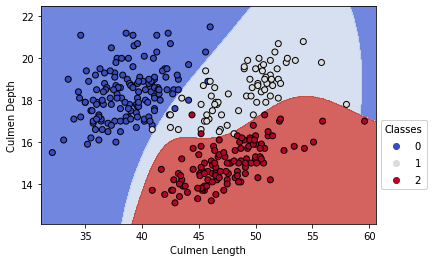

In [42]:
fig, ax = plt.subplots()

h = .02

# create a mesh to plot in
x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = fit_cl_cd.predict(np.c_[xx.ravel(), yy.ravel()])

# put the result into a color plot
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

# create the scatterplot
scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap=plt.cm.coolwarm, edgecolors='black')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(), bbox_to_anchor=(1, 0.5), title="Classes")
ax.add_artist(legend1)

# add axis labels
ax.set_xlabel("Culmen Length")
ax.set_ylabel("Culmen Depth")

plt.show()


### 2. Culmen Length vs. Flipper Length

We first separate the culmen length and flipper length into a separate dataframe.

In [28]:
data_cl_fl = data[:,[0,2]]

In [29]:
data_cl_fl[:5]

array([[ 39.1, 181. ],
       [ 39.5, 186. ],
       [ 40.3, 195. ],
       [ 36.7, 193. ],
       [ 39.3, 190. ]])

We then split the data into training and test sets. Here, we have used a test size of 20% of the data. The random state is the same as the set.seed() function in $R$, which allows the data to be replicable.

In [30]:
x_train, x_test, y_train, y_test = train_test_split(data_cl_fl, labels, test_size = 0.20, random_state=30)

We fit the data to a radial kernel with a cost of 1 and gamma of 1 to begin.

In [31]:
fit_cl_fl = SVC(kernel = 'rbf', C=1, gamma=1).fit(x_train, y_train)
fit_cl_fl.predict(x_test)
print('Classifier yields accuracy of {:2.5f}%'.format(fit_cl_fl.score(x_test,y_test)*100))

Classifier yields accuracy of 88.05970%


We again use the GridSearch function to find and print the best parameters.

In [32]:
param_grid = {'C': [0.01, 0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,'auto','scale'],'kernel': ['rbf']}
grid = GridSearchCV(fit_cl_fl,param_grid,refit=True,verbose=2)
grid.fit(x_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.01, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.01, gamma=0.0

[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .......................C=100, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=100, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=100, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=100, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=100, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END ...................

GridSearchCV(estimator=SVC(C=1, gamma=1),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 'auto', 'scale'],
                         'kernel': ['rbf']},
             verbose=2)

In [33]:
print(grid.best_estimator_)

SVC(C=10, gamma=0.01)


We now fit the final model with the parameters given by the GridSearch function. Note that we now see a higher accuracy.

In [34]:
fit_cl_fl = SVC(kernel = 'rbf', C=10, gamma=0.01).fit(x_train,y_train)
fit_cl_fl.predict(x_test)
print('Classifier yields accuracy of {:2.5f}%'.format(fit_cl_fl.score(x_test,y_test)*100))

Classifier yields accuracy of 97.01493%


Finally, we plot the data to see the correlating decision boundary of the support vector machine. A class of 0 corresponds to Adelie, 1 to Chinstrap, and 2 to Gentoo.

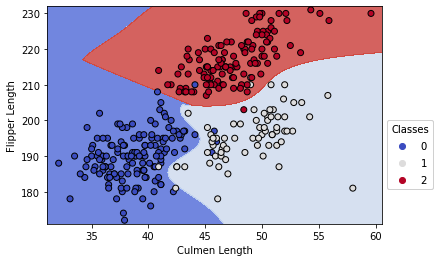

In [43]:
fig, ax = plt.subplots()

h = .02

# create a mesh to plot in
x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
y_min, y_max = data[:, 2].min() - 1, data[:, 2].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = fit_cl_fl.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

scatter = ax.scatter(data[:, 0], data[:, 2], c=labels, cmap=plt.cm.coolwarm, edgecolors='black')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(), bbox_to_anchor=(1, 0.5), title="Classes")
ax.add_artist(legend1)

# add axis labels
ax.set_xlabel("Culmen Length")
ax.set_ylabel("Flipper Length")

plt.show()


### 3. Culmen Length vs. Body Mass

We first separate the culmen length and body mass into a separate dataframe.

In [35]:
data_cl_bm = data[:,[0,3]]

In [36]:
data_cl_bm[:5]

array([[  39.1, 3750. ],
       [  39.5, 3800. ],
       [  40.3, 3250. ],
       [  36.7, 3450. ],
       [  39.3, 3650. ]])

We then split the data into training and test sets. Here, we have used a test size of 20% of the data. The random state is the same as the set.seed() function in $R$, which allows the data to be replicable.

In [37]:
x_train, x_test, y_train, y_test = train_test_split(data_cl_bm, labels, test_size = 0.20, random_state=30)

We fit the data to a radial kernel with a cost of 1 and gamma of 1 to begin.

In [38]:
fit_cl_bm = SVC(kernel = 'rbf', C=1, gamma=1).fit(x_train,y_train)
fit_cl_bm.predict(x_test)
print('Classifier yields accuracy of {:2.5f}%'.format(fit_cl_bm.score(x_test,y_test)*100))

Classifier yields accuracy of 74.62687%


We again use the GridSearch function to find and print the best parameters.

In [39]:
param_grid = {'C': [0.01, 0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,'auto','scale'],'kernel': ['rbf']}
grid = GridSearchCV(fit_cl_bm,param_grid,refit=True,verbose=2)
grid.fit(x_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.01, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.01, gamma=0.0

[CV] END ......................C=10, gamma=0.001, kernel=rbf; total time=   0.0s
[CV] END .......................C=10, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .......................C=10, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .......................C=10, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .......................C=10, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .......................C=10, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...................

GridSearchCV(estimator=SVC(C=1, gamma=1),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 'auto', 'scale'],
                         'kernel': ['rbf']},
             verbose=2)

In [40]:
print(grid.best_estimator_)

SVC(C=1000, gamma=0.001)


We now fit the final model with the parameters given by the GridSearch function. Note that we now see a higher accuracy.

In [41]:
fit_cl_bm = SVC(kernel = 'rbf', C=1000, gamma=0.001).fit(x_train,y_train)
fit_cl_bm.predict(x_test)
print('Classifier yields accuracy of {:2.5f}%'.format(fit_cl_bm.score(x_test,y_test)*100))

Classifier yields accuracy of 79.10448%


Finally, we plot the data to see the correlating decision boundary of the support vector machine. A class of 0 corresponds to Adelie, 1 to Chinstrap, and 2 to Gentoo.

In [ ]:
fig, ax = plt.subplots()

h = .02

# create a mesh to plot in
x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
y_min, y_max = data[:, 3].min() - 1, data[:, 3].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = fit_cl_bm.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

scatter = ax.scatter(data[:, 0], data[:, 3], c=labels, cmap=plt.cm.coolwarm, edgecolors='black')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(), bbox_to_anchor=(1, 0.5), title="Classes")
ax.add_artist(legend1)

# add axis labels
ax.set_xlabel("Culmen Length")
ax.set_ylabel("Body Mass")

plt.show()


## Using all 4 predictors

First, we split the data.

In [42]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = 0.20, random_state=30)

We fit the data to a radial kernel with a cost of 1 and gamma of 1 to begin.

In [43]:
fit_all = SVC(kernel = 'rbf', C=1, gamma=1).fit(x_train,y_train)
fit_all.predict(x_test)
print('Classifier yields accuracy of {:2.5f}%'.format(fit_all.score(x_test,y_test)*100))

Classifier yields accuracy of 55.22388%


We fine tune the model using the GridSearch function.

In [44]:
param_grid = {'C': [0.01, 0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,'auto','scale'],'kernel': ['rbf']}
grid = GridSearchCV(fit_all,param_grid,refit=True,verbose=2)
grid.fit(x_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.01, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.01, gamma=0.0

[CV] END .......................C=10, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .......................C=10, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .......................C=10, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .......................C=10, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ......................C=10, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...................

GridSearchCV(estimator=SVC(C=1, gamma=1),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 'auto', 'scale'],
                         'kernel': ['rbf']},
             verbose=2)

In [45]:
print(grid.best_estimator_)

SVC(C=10, gamma=0.001)


We now fit the final model with the parameters given by the GridSearch function. Note that we now see a higher accuracy. Functions in higher dimensions are difficult to plot, so we bypass the graphs in this prediction.

In [46]:
fit_all = SVC(kernel = 'rbf', C=10, gamma=0.001).fit(x_train,y_train)
fit_all.predict(x_test)
print('Classifier yields accuracy of {:2.5f}%'.format(fit_all.score(x_test,y_test)*100))

Classifier yields accuracy of 79.10448%


## Conclusion

The support vector machines using only culmen length and culmen depth as well as culmen length and flipper length predict the species of penguin with equally the highest accuracy.

### to do:

- format comparison graphs into grid ?
- graphs for case 3